<a href="https://colab.research.google.com/github/MerkulovDaniil/split-sgd/blob/master/Code/Continious_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/fastai/fastai --upgrade
!pip install git+https://github.com/fastai/fastprogress --upgrade
# from fastprogress.fastprogress import master_bar, progress_bar

  Cloning https://github.com/fastai/fastai to /tmp/pip-req-build-yhtlqcum
  Running command git clone -q https://github.com/fastai/fastai /tmp/pip-req-build-yhtlqcum
  Created wheel for fastai: filename=fastai-1.0.61.dev0-cp36-none-any.whl size=237840 sha256=0eb3782866108a478f08d26cfe43483b7b277dacebafc48de00a392623bd3a16
  Stored in directory: /tmp/pip-ephem-wheel-cache-qdnya8gk/wheels/83/30/a0/6fa8a74c9f5a5ab45cdc84e9f9ed56d8a72750e11ebf50a364
Successfully built fastai
  Found existing installation: fastai 1.0.61.dev0
    Uninstalling fastai-1.0.61.dev0:
      Successfully uninstalled fastai-1.0.61.dev0
  Cloning https://github.com/fastai/fastprogress to /tmp/pip-req-build-ifqruuot
  Running command git clone -q https://github.com/fastai/fastprogress /tmp/pip-req-build-ifqruuot
  Created wheel for fastprogress: filename=fastprogress-0.2.3-cp36-none-any.whl size=12049 sha256=9a297b2241a6b3ead281a588f66f0b5ef7f57db289712ab08603e43843a47e08
  Stored in directory: /tmp/pip-ephem-wheel-ca

# General splitting and balancing

## Linear regression

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  0%|          | 3/7000 [00:00<04:45, 24.54it/s]

QR finished
🤖 GF trajectory started


100%|██████████| 7000/7000 [08:30<00:00, 13.71it/s]


🤖 GF trajectory finished
🤖 SGD trajectory started
🤖 SGD trajectory finished
🤖 Splitting I trajectory started
🤖 Splitting I trajectory finished
🤖 Splitting II trajectory started
🤖 Splitting II trajectory finished


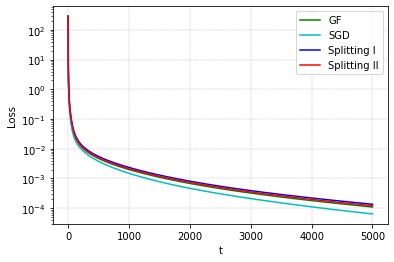

In [5]:
# ======= Libraries =======
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm, qr
import copy
from fastprogress.fastprogress import master_bar, progress_bar

# ======= Function definitions =======

def generate_problem(p, n, lstsq=False, epsilon = 0):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + epsilon*np.random.randn(n) # right-hand side
    theta_0 = np.random.randn(p)

    if lstsq == True:
        theta_lstsq = np.linalg.lstsq(X,y)[0]
        return X, theta_0, y, theta_lstsq
    else:
        return X, theta_0, y

def solve_local_problem(Q, R, theta_0, y_batch, h, n):
    R_it = np.linalg.inv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0)

def solve_local_problem_b_1(x, theta_0, y, h, n):
    x = x.T
    norm = x.T @ x
    return theta_0 + (1 - np.exp(-norm*h/n))*(y - x.T @ theta_0)/norm*x

def loss(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    '''
    if len(X.shape) == 2:
        n, p = X.shape
        return 1/n*np.linalg.norm(X @ theta - y)**2
    elif len(X.shape) == 3:
        s, b, p = Xs.shape
        n = b*s

        loss = 0
        for i_batch in range(s):
            loss += 1/n*np.linalg.norm(X[i_batch] @ theta - y[i_batch])**2
        return loss
    else:
        raise ValueError('🤔 Inappropriate format of dataset')


def gradient(X, theta, y):
    n, p = X.shape
    return 1/n* X.T @ (X @ theta - y)

def make_SGD_step(X_batch, theta_0, y_batch, lr):
    theta = theta_0 - lr*gradient(X_batch, theta_0, y_batch)
    return theta

def relative_error(theta, thetalstsq=0):
    p = len(theta)
    if np.linalg.norm(thetalstsq) != 0:
        return(np.linalg.norm(theta - thetalstsq)/np.linalg.norm(thetalstsq))
    else:
        return(np.linalg.norm(theta - np.ones(p))/np.linalg.norm(np.ones(p)))

def logarithmic_norm(A):
    w,v = np.linalg.eig((A + A.T)/2)
    return(max(w))

def gradient_flow_trajectory(Q, R, theta_0, y, ts):
    p, n = Q.shape
    print('🤖 GF trajectory started')
    thetas = []
    losses = []

    for t in progress_bar(ts):
        # print(t)
        theta_t = solve_local_problem(Q, R, theta_0, y, t, n)
        thetas.append(theta_t)
        loss_t = loss(R.T@Q.T, theta_t, y)
        losses.append(loss_t)
    
    print('🤖 GF trajectory finished')

    return thetas, losses

def sgd_trajectory(Xs, theta_0, ys, lr, N_epoch):
    print('🤖 SGD trajectory started')
    s, b, p = Xs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    for i_t in progress_bar(range(N_epoch)):
        h = lr*n/b
        t+=h
        ts.append(t)
        thetas.append(theta_t)
        loss_t = loss(Xs, theta_t, ys)
        losses.append(loss_t)

        for i_batch in range(s):
            theta_t = make_SGD_step(Xs[i_batch], theta_t, ys[i_batch], lr)

    thetas.append(theta_t)
    loss_t = loss(Xs, theta_t, ys)
    losses.append(loss_t)  
    
    print('🤖 SGD trajectory finished')

    return thetas, losses, ts

def spl_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting I trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s):
            # ts_new.append(ts[i_t] + i_batch*h/s)
            # thetas.append(theta_t)
            # loss_t = loss(Xs, theta_t, ys)
            # losses.append(loss_t)
            theta_prev = theta_t
            theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h, n)
            # print(np.linalg.norm(theta_t - theta_prev))
       
    
    print('🤖 Splitting I trajectory finished')

    return thetas, losses

def spl2_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting II trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        # print(h)
        for i_batch in range(s-1):
            # ts_new.append(ts[i_t] + i_batch*h/(2*s))
            # thetas.append(theta_t)
            # loss_t = loss(Xs, theta_t, ys)
            # losses.append(loss_t)
            theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
        
        # ts_new.append(ts[i_t] + h/(*s))
        # thetas.append(theta_t)
        # loss_t = loss(Xs, theta_t, ys)
        # losses.append(loss_t)
        theta_t = solve_local_problem(Qs[s-1], Rs[s-1], theta_t, ys[s-1], h, n)

        for j_batch in range(s-1):
            i_batch = s - (j_batch + 2) 
            # ts_new.append(ts[i_t] + j_batch*h/(2*s))
            # thetas.append(theta_t)
            # loss_t = loss(Xs, theta_t, ys)
            # losses.append(loss_t)
            theta_t = solve_local_problem(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
    
    print('🤖 Splitting II trajectory finished')

    return thetas, losses

# ======= Problem generation =======

p = 300
n = 300
s = 10
b = 30
epsilon = 0

X, theta_0, y, theta_lstsq = generate_problem(p,n, lstsq=True, epsilon=epsilon)

Xs = np.zeros((s, b, p))
ys = np.zeros((s, b))
Qs = np.zeros((s, p, b))
Rs = np.zeros((s, b, b))
Q, R = qr(X.T, mode='economic')

for i_batch in range(s):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('QR finished')

theta_0     = np.random.randn(p)
theta_0     = theta_0/np.linalg.norm(theta_0)
total_time  = 5000
learning_rate = 5e-2
h_size = 0.75
N_epochs = int(total_time*b/(learning_rate*n))
ts_gf = np.linspace(0, total_time, int(total_time/(h_size)))
ts_spl = np.linspace(0, total_time, int(total_time/(h_size)))

# ======= Trajectory generation =======
thetas_gf, losses_gf    = gradient_flow_trajectory(Q, R, theta_0, y, ts_gf)
thetas_sgd, losses_sgd, ts_sgd  = sgd_trajectory(Xs, theta_0, ys, learning_rate, N_epochs)
thetas_spl, losses_spl = spl_trajectory(Qs, Rs, theta_0, ys, ts_spl)
thetas_spl2, losses_spl2 = spl2_trajectory(Qs, Rs, theta_0, ys, ts_spl)

🤓 Spline interpolation for GF
🤓 Spline interpolation for SGD
🤓 Spline interpolation for Splitting I
🤓 Spline interpolation for Splitting II


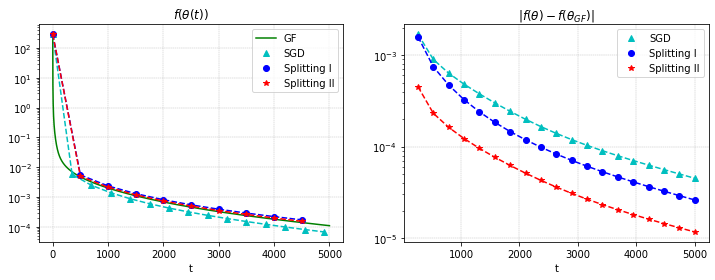

In [68]:
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between x.min and x.max
print('🤓 Spline interpolation for GF')
x_gf = ts_gf
y_gf = losses_gf

xnew = np.linspace(min(x_gf), max(x_gf), 20) 

spl_gf = make_interp_spline(x_gf, y_gf, k=3)
y_gf_smooth = spl_gf(xnew)

print('🤓 Spline interpolation for SGD')
x_sgd = ts_sgd
y_sgd = losses_sgd

spl_sgd = make_interp_spline(x_sgd, y_sgd, k=3)
y_sgd_smooth = spl_sgd(xnew)

print('🤓 Spline interpolation for Splitting I')
x_spl = ts_spl
y_spl = losses_spl

spl_spl = make_interp_spline(x_spl, y_spl, k=3) 
y_spl_smooth = spl_spl(xnew)

print('🤓 Spline interpolation for Splitting II')
x_spl = ts_spl
y_spl = losses_spl2

spl_spl = make_interp_spline(x_spl, y_spl, k=3)
y_spl2_smooth = spl_spl(xnew)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_true[:-1], 'go', label = 'True')
# plt.semilogy(np.linspace(0,total_time, repetitions), par_residuals_true[:-1], 'g')
axs[0].semilogy(ts_gf, losses_gf, 'g', label = 'GF')
axs[0].semilogy(ts_sgd[::700], losses_sgd[::700], 'c^', label = 'SGD')
axs[0].semilogy(ts_sgd[::700], losses_sgd[::700], 'c--')
axs[0].semilogy(ts_spl[::700], losses_spl[::700], 'bo', label = 'Splitting I')
axs[0].semilogy(ts_spl[::700], losses_spl[::700], 'b--')
axs[0].semilogy(ts_spl[::700], losses_spl2[::700], 'r*', label = 'Splitting II')
axs[0].semilogy(ts_spl[::700], losses_spl2[::700], 'r--')
axs[0].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
axs[0].set_xlabel('t')
axs[0].set_title(r'$f\left(\theta(t)\right)$')
axs[0].legend()

axs[1].semilogy(xnew[1:], np.abs(np.array(y_sgd_smooth[1:]) - np.array(y_gf_smooth[1:])), 'c^', label = 'SGD')
axs[1].semilogy(xnew[1:], np.abs(np.array(y_sgd_smooth[1:]) - np.array(y_gf_smooth[1:])), 'c--')
axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl_smooth[1:]) - np.array(y_gf_smooth[1:])), 'bo', label = 'Splitting I')
axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl_smooth[1:]) - np.array(y_gf_smooth[1:])), 'b--')
axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl2_smooth[1:]) - np.array(y_gf_smooth[1:])), 'r*', label = 'Splitting II')
axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl2_smooth[1:]) - np.array(y_gf_smooth[1:])), 'r--')
axs[1].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
axs[1].set_xlabel('t')
axs[1].set_title(r'$\|f(\theta) - f(\theta_{GF})\|$')
axs[1].legend()

# plt.savefig('sgd_split_step_n{}.svg'.format(epsilon))
plt.savefig('ct_lls.pdf')
plt.show()

## Logistic regression
### Splitting vs SGD

In [74]:
# ======= Libraries =======

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint
from scipy.linalg import expm, qr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import copy
from fastprogress.fastprogress import master_bar, progress_bar
import random
random.seed(999)
np.random.seed(999)

# ======= Function definitions =======


def sigmoid(x):
    '''
    Calculates element-wise sigmoid function
    Parameters
    ----------
    x : array-like of floats
        Input vector (scalar)
    Returns
    -------
    sigma(x) : array-like of floats
        1/(1 + exp(-x_i)) for each x_i in x
    '''
    if np.isscalar(x):
        return 1/(1 + np.exp(-x))
    else:
        return np.array([1/(1 + np.exp(-x_i)) for x_i in x])

def make_splitting_step(Q, R, theta_0, y, h, n):
    h_seq = [0, h]
    eta_0 = Q.T@theta_0
    def rhs(eta, t):
        return -1/n * R@(sigmoid(R.T @ eta) - np.array(y))
    eta_h = odeint(rhs, eta_0, h_seq)[-1]

    theta = Q@(eta_h - eta_0) + theta_0
    return theta

# def gradient(X, theta, y):
#     n, p = X.shape
#     return 1/n* X.T @ (sigmoid(X @ theta) - y)

# def make_SGD_step(X_batch, theta_0, y_batch, lr):
#     theta = theta_0 - lr*gradient(X_batch, theta_0, y_batch)
#     return theta


def loss_logreg(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    This version is already normalized (1/n)
    '''
    if len(X.shape) == 2:
        y_pred = [sigmoid(theta.T @ x) for x in X]
        y_true = y
        return log_loss(y_true, y_pred, normalize = True)
    elif len(X.shape) == 3:
        s, b, p = Xs.shape
        n = b*s

        loss = 0
        for i_batch in range(s):
            y_pred = [sigmoid(theta.T @ x) for x in Xs[i_batch]]
            y_true = ys[i_batch]
            loss += 1/n*log_loss(y_true, y_pred, normalize = False)
        return loss
    else:
        raise ValueError('🤔 Inappropriate format of dataset')

def generate_problem_logistic_regression():
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.data.to(dtype=torch.float)/255
    y_train = trainset.targets
    X_train.resize_(len(X_train),  X_train[0].shape[0]*X_train[0].shape[1])
    y_train.view(-1).long()

    indicies0 = y_train == 0
    indicies1 = y_train == 1
    return X_train[indicies0 + indicies1], y_train[indicies0 + indicies1]

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(p, 1)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

def loss_moving_average(loss, window=50):
    if loss == []:
        return 1000
    else:
        return(np.average(loss[-window:]))

def gradient_flow_trajectory(Q, R, theta_0, y, ts):
    p, n = R.shape
    print(n)
    print('🤖 GF trajectory started')
    thetas = []
    losses = []
    theta_t = theta_0

    for t in progress_bar(ts):
        # This is not splitting, actually, since we use the whole sample as a 
        # batch. It is ODEint solution of the whole ODE
        theta_t = make_splitting_step(Q, R, theta_t, y, t, n)
        thetas.append(theta_t)
        loss_t = loss_logreg(R.T@Q.T, theta_t, y)
        losses.append(loss_t)
    
    print('🤖 GF trajectory finished')

    return thetas, losses

def gradient_flow_euler_trajectory(X, theta_0, y, lr, N_epoch, model):
    print('🤖 GF Euler trajectory started')
    n, p = X.shape
    thetas = []
    losses = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    theta = copy.deepcopy(theta_0)
    model.train()
    for parameter in model.parameters():
        # Working with weights only
        parameter.data[0] = torch.from_numpy(theta)
        break
    for i_t in progress_bar(range(N_epoch)):
        h = lr
        t+= h 
        # X_batch = torch.from_numpy(X).float()
        # y_batch = torch.from_numpy(y).float()
        X, y = X.float(), y.float()
        
        model.zero_grad()
        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred.view(-1), y.view(-1))
        ts.append(t)
        thetas.append(theta_t)
        losses.append(loss.data)
        # Backward pass
        loss.backward()
        for parameter in model.parameters():
            parameter.data = parameter.data - lr*parameter.grad.data
            theta_t = np.array(parameter.data[0].T)
            break
            # theta_t = np.array(parameter.data[0].T)

    thetas.append(theta_t)
    losses.append(loss.data)  
    
    print('🤖 GF Euler trajectory finished')

    return thetas, losses, ts

def sgd_trajectory(Xs, theta_0, ys, lr, N_epoch, model):
    print('🤖 SGD trajectory started')
    s, b, p = Xs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    theta = copy.deepcopy(theta_0)
    model.train()
    for parameter in model.parameters():
        # Working with weights only
        parameter.data[0] = torch.from_numpy(theta)
        break
    for i_t in progress_bar(range(N_epoch)):
        h = lr*n/b
        t+=h
        ts.append(t)
        thetas.append(theta_t)
        loss_t = loss_logreg(Xs, theta_t, ys)
        losses.append(loss_t)

        for i_batch in range(s):
            X_batch = torch.from_numpy(Xs[i_batch]).float()
            y_batch = torch.from_numpy(ys[i_batch]).float()
            model.zero_grad()
            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred.view(-1), y_batch.view(-1))
            # Backward pass
            loss.backward()
            for parameter in model.parameters():
                parameter.data = parameter.data - lr*parameter.grad.data
                theta_t = np.array(parameter.data[0].T)
                break
            # theta_t = np.array(parameter.data[0].T)

    thetas.append(theta_t)
    loss_t = loss_logreg(Xs, theta_t, ys)
    losses.append(loss_t)  
    
    print('🤖 SGD trajectory finished')

    return thetas, losses, ts

def spl_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting I trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss_logreg(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s):
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h, n)       
    
    print('🤖 Splitting I trajectory finished')

    return thetas, losses

def spl2_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting II trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss_logreg(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s-1):
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
        
        theta_t = make_splitting_step(Qs[s-1], Rs[s-1], theta_t, ys[s-1], h, n)

        for j_batch in range(s-1):
            i_batch = s - (j_batch + 2) 
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
    
    print('🤖 Splitting II trajectory finished')

    return thetas, losses

# ======= Problem generation =======

p = 784
n = 12665
b = 64
s = n//b

total_time  = 2
learning_rate = 1e-1
h_size = 0.9
N_epochs            = int(total_time*b/(learning_rate*n))
N_cycles            = int(total_time/(h_size))
N_gf_euler_steps    = int(total_time/learning_rate)
print('🤓 Number of SGD epochs: {}, Number of Splitting cycles: {}'.format(N_epochs, N_cycles))
print('🤓 Number of GD steps (Euler GF approximation) {}'.format(N_gf_euler_steps))
ts_gf  = np.linspace(0, total_time, N_cycles)
ts_spl = np.linspace(0, total_time, N_cycles)

X, y = generate_problem_logistic_regression()
print('🤓 Data loaded')
theta_0 = np.random.randn(p)

model = LogisticRegression()
criterion = nn.BCELoss(reduction = 'mean')
print('🤓 Model loaded')

Xs = np.zeros((s, b, p))
ys = np.zeros((s, b))
Qs = np.zeros((s, p, b))
Rs = np.zeros((s, b, b))
Q, R = qr(X.T, mode='economic')

for i_batch in range(s):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('🤓 QR finished')

# ======= Trajectory generation =======
thetas_gf_eu, losses_gf_eu, ts_gf_eu    = gradient_flow_euler_trajectory(X, theta_0, y, learning_rate, N_gf_euler_steps, model)
# thetas_spl2, losses_spl2                = spl2_trajectory(Qs, Rs, theta_0, ys, ts_spl)
# thetas_spl, losses_spl                  = spl_trajectory(Qs, Rs, theta_0, ys, ts_spl)
# thetas_sgd, losses_sgd, ts_sgd          = sgd_trajectory(Xs, theta_0, ys, learning_rate, N_epochs, model)
thetas_gf, losses_gf                    = gradient_flow_trajectory(Q, R, theta_0, y, ts_gf)

# thetas_spl, losses_spl = spl_trajectory(Qs, Rs, theta_0, ys, ts_spl)
# thetas_spl2, losses_spl2 = spl2_trajectory(Qs, Rs, theta_0, ys, ts_spl)

🤓 Number of SGD epochs: 0, Number of Splitting cycles: 2
🤓 Number of GD steps (Euler GF approximation) 20
🤓 Data loaded
🤓 Model loaded
🤓 QR finished
🤖 GF Euler trajectory started


🤖 GF Euler trajectory finished
12665
🤖 GF trajectory started


🤖 GF trajectory finished


In [66]:

np.random.randn(2)

array([0.12715784, 1.40189088])

No handles with labels found to put in legend.


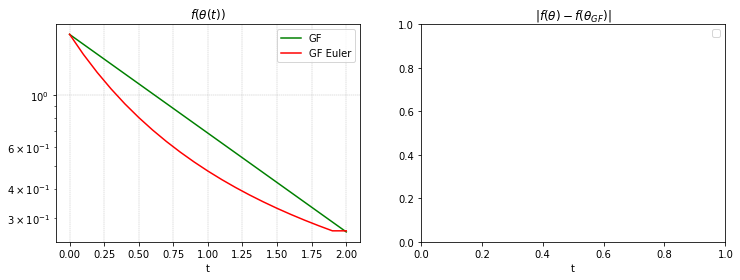

In [75]:
from scipy.interpolate import make_interp_spline, BSpline

# # 300 represents number of points to make between x.min and x.max
# print('🤓 Spline interpolation for GF')
# x_gf = ts_gf
# y_gf = losses_gf

# xnew = np.linspace(min(x_gf), max(x_gf), 20) 

# spl_gf = make_interp_spline(x_gf, y_gf, k=3)
# y_gf_smooth = spl_gf(xnew)

# print('🤓 Spline interpolation for SGD')
# x_sgd = ts_sgd
# y_sgd = losses_sgd

# spl_sgd = make_interp_spline(x_sgd, y_sgd, k=3)
# y_sgd_smooth = spl_sgd(xnew)

# print('🤓 Spline interpolation for Splitting I')
# x_spl = ts_spl
# y_spl = losses_spl

# spl_spl = make_interp_spline(x_spl, y_spl, k=3) 
# y_spl_smooth = spl_spl(xnew)

# print('🤓 Spline interpolation for Splitting II')
# x_spl = ts_spl
# y_spl = losses_spl2

# spl_spl = make_interp_spline(x_spl, y_spl, k=3)
# y_spl2_smooth = spl_spl(xnew)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].semilogy(ts_gf,      losses_gf, 'g', label = 'GF')
axs[0].semilogy(ts_gf_eu,   losses_gf_eu, 'r', label = 'GF Euler')
# axs[0].semilogy(ts_sgd,     losses_sgd, 'c^', label = 'SGD')
# axs[0].semilogy(ts_sgd,     losses_sgd, 'c--')
# axs[0].semilogy(ts_spl,     losses_spl, 'bo', label = 'Splitting I')
# axs[0].semilogy(ts_spl,     losses_spl, 'b--')
# axs[0].semilogy(ts_spl,     losses_spl2, 'r*', label = 'Splitting II')
# axs[0].semilogy(ts_spl,     losses_spl2, 'r--')
axs[0].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
axs[0].set_xlabel('t')
axs[0].set_title(r'$f\left(\theta(t)\right)$')
axs[0].legend()

# axs[1].semilogy(xnew[1:], np.abs(np.array(y_sgd_smooth[1:]) - np.array(y_gf_smooth[1:])), 'c^', label = 'SGD')
# axs[1].semilogy(xnew[1:], np.abs(np.array(y_sgd_smooth[1:]) - np.array(y_gf_smooth[1:])), 'c--')
# axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl_smooth[1:]) - np.array(y_gf_smooth[1:])), 'bo', label = 'Splitting I')
# axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl_smooth[1:]) - np.array(y_gf_smooth[1:])), 'b--')
# axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl2_smooth[1:]) - np.array(y_gf_smooth[1:])), 'r*', label = 'Splitting II')
# axs[1].semilogy(xnew[1:], np.abs(np.array(y_spl2_smooth[1:]) - np.array(y_gf_smooth[1:])), 'r--')
# axs[1].grid(True, linestyle='--', linewidth=0.4)
# plt.grid()
axs[1].set_xlabel('t')
axs[1].set_title(r'$\|f(\theta) - f(\theta_{GF})\|$')
axs[1].legend()

# plt.savefig('sgd_split_step_n{}.svg'.format(epsilon))
plt.savefig('ct_logreg.pdf')
plt.show()

### Splitting by class

In [22]:
# ======= Libraries =======

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint
from scipy.linalg import expm, qr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import copy
from fastprogress.fastprogress import master_bar, progress_bar

# ======= Function definitions =======


def sigmoid(x):
    '''
    Calculates element-wise sigmoid function
    Parameters
    ----------
    x : array-like of floats
        Input vector (scalar)
    Returns
    -------
    sigma(x) : array-like of floats
        1/(1 + exp(-x_i)) for each x_i in x
    '''
    if np.isscalar(x):
        return 1/(1 + np.exp(-x))
    else:
        return np.array([1/(1 + np.exp(-x_i)) for x_i in x])

def make_splitting_step(Q, R, theta_0, y, h, n):
    h_seq = [0, h]
    eta_0 = Q.T@theta_0
    def rhs(eta, t):
        return -1/n * R@(sigmoid(R.T @ eta) - np.array(y))
    eta_h = odeint(rhs, eta_0, h_seq)[-1]

    theta = Q@(eta_h - eta_0) + theta_0
    return theta

# def gradient(X, theta, y):
#     n, p = X.shape
#     return 1/n* X.T @ (sigmoid(X @ theta) - y)

# def make_SGD_step(X_batch, theta_0, y_batch, lr):
#     theta = theta_0 - lr*gradient(X_batch, theta_0, y_batch)
#     return theta


def loss_logreg(X, theta, y):
    '''
    Supports batch reformulation. The difference in dimension of the input
    This version is already normalized (1/n)
    '''
    if len(X.shape) == 2:
        y_pred = [sigmoid(theta.T @ x) for x in X]
        y_true = y
        return log_loss(y_true, y_pred, normalize = True)
    elif len(X.shape) == 3:
        s, b, p = Xs.shape
        n = b*s

        loss = 0
        for i_batch in range(s):
            y_pred = [sigmoid(theta.T @ x) for x in Xs[i_batch]]
            y_true = ys[i_batch]
            loss += 1/n*log_loss(y_true, y_pred, normalize = False)
        return loss
    else:
        raise ValueError('🤔 Inappropriate format of dataset')

def generate_problem_logistic_regression(class_splitting=False):
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.data.to(dtype=torch.float)/255
    y_train = trainset.targets
    X_train.resize_(len(X_train),  X_train[0].shape[0]*X_train[0].shape[1])
    y_train.view(-1).long()

    indicies0 = y_train == 0
    indicies1 = y_train == 1
    if class_splitting:
        return np.concatenate(X_train[indicies0], X_train[indicies1]), np.concatenate(y_train[indicies0], y_train[indicies1])
    else:
        return X_train[indicies0 + indicies1], y_train[indicies0 + indicies1]

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(p, 1)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

def loss_moving_average(loss, window=50):
    if loss == []:
        return 1000
    else:
        return(np.average(loss[-window:]))

def gradient_flow_trajectory(Q, R, theta_0, y, ts):
    p, n = R.shape
    print(n)
    print('🤖 GF trajectory started')
    thetas = []
    losses = []
    theta_t = theta_0

    for t in progress_bar(ts):
        # This is not splitting, actually, since we use the whole sample as a 
        # batch. It is ODEint solution of the whole ODE
        theta_t = make_splitting_step(Q, R, theta_t, y, t, n)
        thetas.append(theta_t)
        loss_t = loss_logreg(R.T@Q.T, theta_t, y)
        losses.append(loss_t)
    
    print('🤖 GF trajectory finished')

    return thetas, losses

def gradient_flow_euler_trajectory(X, theta_0, y, lr, N_epoch, model):
    print('🤖 GF Euler trajectory started')
    n, p = X.shape
    thetas = []
    losses = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    theta = copy.deepcopy(theta_0)
    model.train()
    for parameter in model.parameters():
        # Working with weights only
        parameter.data[0] = torch.from_numpy(theta)
        break
    for i_t in progress_bar(range(N_epoch)):
        h = lr
        t+= h 
        # X_batch = torch.from_numpy(X).float()
        # y_batch = torch.from_numpy(y).float()
        X, y = X.float(), y.float()
        
        model.zero_grad()
        # Forward pass
        y_pred = model(X)
        loss = criterion(y_pred.view(-1), y.view(-1))
        ts.append(t)
        thetas.append(theta_t)
        losses.append(loss.data)
        # Backward pass
        loss.backward()
        for parameter in model.parameters():
            parameter.data = parameter.data - lr*parameter.grad.data
            theta_t = np.array(parameter.data[0].T)
            break
            # theta_t = np.array(parameter.data[0].T)

    thetas.append(theta_t)
    losses.append(loss.data)  
    
    print('🤖 GF Euler trajectory finished')

    return thetas, losses, ts

def sgd_trajectory(Xs, theta_0, ys, lr, N_epoch, model):
    print('🤖 SGD trajectory started')
    s, b, p = Xs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts = []
    t = 0
    ts.append(t)
    theta = copy.deepcopy(theta_0)
    model.train()
    for parameter in model.parameters():
        # Working with weights only
        parameter.data[0] = torch.from_numpy(theta)
        break
    for i_t in progress_bar(range(N_epoch)):
        h = lr*n/b
        t+=h
        ts.append(t)
        thetas.append(theta_t)
        loss_t = loss_logreg(Xs, theta_t, ys)
        losses.append(loss_t)

        for i_batch in range(s):
            X_batch = torch.from_numpy(Xs[i_batch]).float()
            y_batch = torch.from_numpy(ys[i_batch]).float()
            model.zero_grad()
            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred.view(-1), y_batch.view(-1))
            # Backward pass
            loss.backward()
            for parameter in model.parameters():
                parameter.data = parameter.data - lr*parameter.grad.data
                theta_t = np.array(parameter.data[0].T)
                break
            # theta_t = np.array(parameter.data[0].T)

    thetas.append(theta_t)
    loss_t = loss_logreg(Xs, theta_t, ys)
    losses.append(loss_t)  
    
    print('🤖 SGD trajectory finished')

    return thetas, losses, ts

def spl_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting I trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss_logreg(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s):
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h, n)       
    
    print('🤖 Splitting I trajectory finished')

    return thetas, losses

def spl2_trajectory(Qs, Rs, theta_0, ys, ts):
    print('🤖 Splitting II trajectory started')
    s, p, b = Qs.shape
    n = b*s
    thetas = []
    losses = []
    theta_t = theta_0
    ts_new = []
    
    for i_t in progress_bar(range(len(ts))):
        t = ts[i_t]
        thetas.append(theta_t)
        loss_t = loss_logreg(Xs, theta_t, ys)
        losses.append(loss_t)
        
        if t == ts[-1]:
            break

        h = ts[i_t+1] - ts[i_t]
        for i_batch in range(s-1):
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
        
        theta_t = make_splitting_step(Qs[s-1], Rs[s-1], theta_t, ys[s-1], h, n)

        for j_batch in range(s-1):
            i_batch = s - (j_batch + 2) 
            theta_t = make_splitting_step(Qs[i_batch], Rs[i_batch], theta_t, ys[i_batch], h/2, n)
    
    print('🤖 Splitting II trajectory finished')

    return thetas, losses

# ======= Problem generation =======

p = 784
n = 12665
b = 64
s = n//b

total_time  = 10
learning_rate = 1e-3
h_size = 0.3
N_epochs            = int(total_time*b/(learning_rate*n))
N_cycles            = int(total_time/(h_size))
N_gf_euler_steps    = int(total_time/learning_rate)
print('🤓 Number of SGD epochs: {}, Number of Splitting cycles: {}'.format(N_epochs, N_cycles))
print('🤓 Number of GD steps (Euler GF approximation) {}'.format(N_gf_euler_steps))
ts_gf  = np.linspace(0, total_time, N_cycles)
ts_spl = np.linspace(0, total_time, N_cycles)

X, y = generate_problem_logistic_regression()
print('🤓 Data loaded')
theta_0 = np.random.randn(p)

model = LogisticRegression()
criterion = nn.BCELoss(reduction = 'mean')
print('🤓 Model loaded')

Xs = np.zeros((s, b, p))
ys = np.zeros((s, b))
Qs = np.zeros((s, p, b))
Rs = np.zeros((s, b, b))
Q, R = qr(X.T, mode='economic')

for i_batch in range(s):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('🤓 QR finished')

# ======= Trajectory generation =======
thetas_gf_eu, losses_gf_eu, ts_gf_eu    = gradient_flow_euler_trajectory(X, theta_0, y, learning_rate, N_gf_euler_steps, model)
# thetas_spl2, losses_spl2                = spl2_trajectory(Qs, Rs, theta_0, ys, ts_spl)
# thetas_spl, losses_spl                  = spl_trajectory(Qs, Rs, theta_0, ys, ts_spl)
# thetas_sgd, losses_sgd, ts_sgd          = sgd_trajectory(Xs, theta_0, ys, learning_rate, N_epochs, model)
thetas_gf, losses_gf                    = gradient_flow_trajectory(Q, R, theta_0, y, ts_gf)

# thetas_spl, losses_spl = spl_trajectory(Qs, Rs, theta_0, ys, ts_spl)
# thetas_spl2, losses_spl2 = spl2_trajectory(Qs, Rs, theta_0, ys, ts_spl)

IndentationError: ignored

In [0]:
mb